In [1]:
import os
import numpy as np
import itertools
import math, random
from glob import glob

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import pandas as pd

import scipy.spatial.distance
import plotly.graph_objects as go
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import pyedflib
from torch.utils.data import Dataset


# Установка Seed для воспроизводимости
seed_value = 42
torch.manual_seed(seed_value)
torch.cuda.manual_seed(seed_value)
torch.cuda.manual_seed_all(seed_value)
np.random.seed(seed_value)
random.seed(seed_value)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

Дополнительные функции

In [2]:
def rename_columns(df):
    # Приводит к правильному виду данные в df:
    new_columns = []
    for column in df.columns:
        new_columns.append(column[:-4])
    df.columns = new_columns
    return df


def discrete_signal_resample(signal, time, new_sampling_rate):
    ## Производит ресемплирование
    # Текущая частота дискретизации
    current_sampling_rate = 1 / np.mean(np.diff(time))

    # Количество точек в новой дискретизации
    num_points_new = int(len(signal) * new_sampling_rate / current_sampling_rate)

    # Используем scipy.signal.resample для изменения дискретизации
    new_signal = scipy.signal.resample(signal, num_points_new)
    new_time = np.linspace(time[0], time[-1], num_points_new)

    return new_signal, new_time


def plot_signals_with_subplot(signal):
    subplot_shape = (signal.shape[0],)
    # subplot_shape - кортеж, указывающий количество строк в сетке subplot
    
    # Проверяем, достаточно ли сигналов для создания всех подграфиков
    if signal.shape[0] < subplot_shape[0]:
        raise ValueError("Недостаточно сигналов для создания всех подграфиков в сетке subplot.")
    
    # Создаем сетку subplot
    fig, axes = plt.subplots(subplot_shape[0], figsize=(8, 7))
    
    # Регулируем расположение графиков
    plt.tight_layout()
    
    # Строим графики для каждого сигнала
    for i in range(subplot_shape[0]):
        axes[i].plot(signal[i])
        axes[i].set_title(f'Signal {i+1}')
    
    # Показываем графики
    plt.show()


def get_full_signal(path, Fs_new=500, f_sreza=0.7):
    # Открываем EDF файл
    f = pyedflib.EdfReader(path)

    # Получаем информацию о каналах
    num_channels = f.signals_in_file
    channels = f.getSignalLabels()

    # Читаем данные по каналам
    raw_data = []
    for i in range(num_channels):
        channel_data = f.readSignal(i)
        raw_data.append(channel_data)

    # Получаем частоту дискретизации
    fd = f.getSampleFrequency(0)

    # Закрываем файл EDF после чтения
    f.close()
    raw_data = np.array(raw_data)

    # Создаем DataFrame
    df = pd.DataFrame(data=raw_data.T,   
            index=range(raw_data.shape[1]), 
            columns=channels)  

    # Переименование столбцов при необходимости:
    if 'ECG I-Ref' in df.columns:
        df = rename_columns(df)
        channels = df.columns

    # Создание массива времени    
    Ts = 1/fd
    t = []
    for i in range(raw_data.shape[1]):
        t.append(i*Ts)

    # Ресемлинг:
    df_new = pd.DataFrame()
    for graph in channels:
        sig = np.array(df[graph])
        new_ecg, time_new = discrete_signal_resample(sig, t, Fs_new)
        df_new[graph] = pd.Series(new_ecg) 
    df = df_new.copy()

    # ФВЧ фильтрация артефактов дыхания:
    df_new = pd.DataFrame()
    for graph in channels:
        sig = np.array(df[graph])
        sos = scipy.signal.butter(1, f_sreza, 'hp', fs=Fs_new, output='sos')
        avg = np.mean(sig)
        filtered = scipy.signal.sosfilt(sos, sig)
        filtered += avg
        df_new[graph] = pd.Series(filtered)
    df = df_new.copy()

    # Выбор нужных столбцов
    selected_columns = ['ECG I', 'ECG II', 'ECG V1', 'ECG V2', 'ECG V3', 'ECG V4', 'ECG V5', 'ECG V6']
    selected_data = df[selected_columns]

    # Преобразование данных в массив NumPy
    numpy_array = selected_data.values.T
    return numpy_array

## Создание датасета

In [3]:
class ECG_signal_data(Dataset):
    def __init__(self, split='train', transform=None, random_seed=42):
        self.df_gt = pd.read_excel('dataset/1250_ef.xlsx', index_col=0)
        self.df_gt['class'] = self.df_gt['EF'].apply(lambda x: 1 if x < 50 else 0)
        self.ecg_paths = glob(f"dataset/Dataset_larger_1250/FULL_DATA/*.edf")
        self.transform = transform
        self.classes = {0: 'normal', 1: 'pathology'}

        # Разделение данных
        train_paths, val_paths = train_test_split(self.ecg_paths, test_size=0.25, random_state=random_seed)

        if split == 'train':
            self.file_paths = train_paths
        elif split == 'val':
            self.file_paths = val_paths
        else:
            raise ValueError("Invalid split parameter. Use 'train' or 'val'.")

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        file_path = self.file_paths[idx]
        signal = get_full_signal(file_path)

        if self.transform:
            signal = self.transform(signal)

        target = self.df_gt.loc[os.path.basename(file_path)]['class']

        return {'signal': signal, 'category': target, 'file_edf': os.path.basename(file_path)}


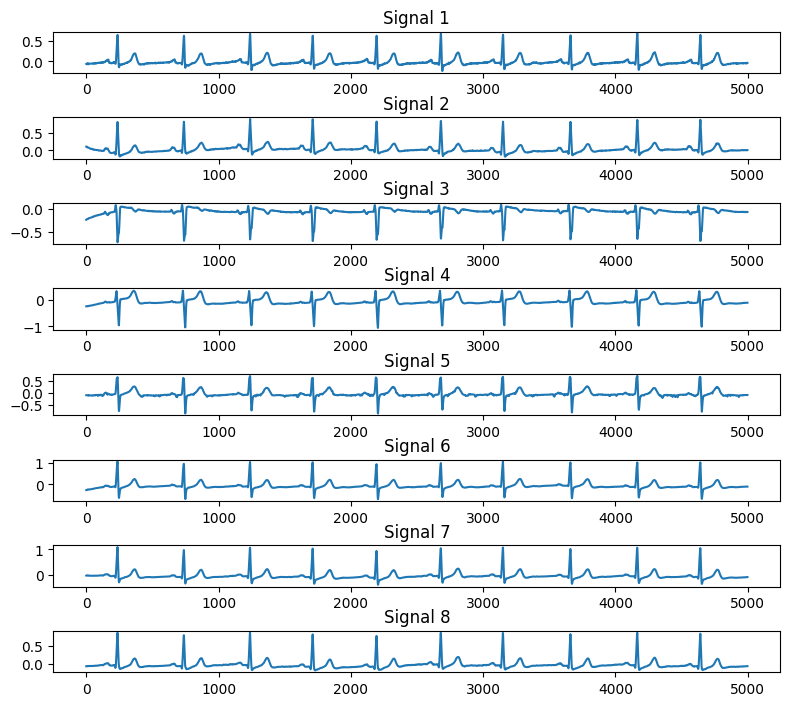

In [4]:
train_ds = ECG_signal_data(split='train', transform=None)
val_ds = ECG_signal_data(split='val', transform=None)

train_ds[0]['signal'].shape
plot_signals_with_subplot(train_ds[0]['signal'])

# Аугментации создаем тут:

In [10]:
class RandomSubsetTransform:
    def __init__(self, subset_length):
        self.subset_length = subset_length

class RandomSubsetTransform:
    def __init__(self, subset_length):
        self.subset_length = subset_length

    def __call__(self, signal):
        # Генерируем случайный индекс начала подпоследовательности
        len_signal = signal.shape[1]
        start_index = np.random.randint(250, len_signal - self.subset_length - 250)
        # 250 - отступ с двух сторон из-за фильтрации (0.5 с)

        # Выбираем подпоследовательность из сигнала
        subset = signal[:, start_index:start_index + self.subset_length]

        return subset

    
class ToTensor(object):
    def __call__(self, signal):
        return torch.from_numpy(signal)

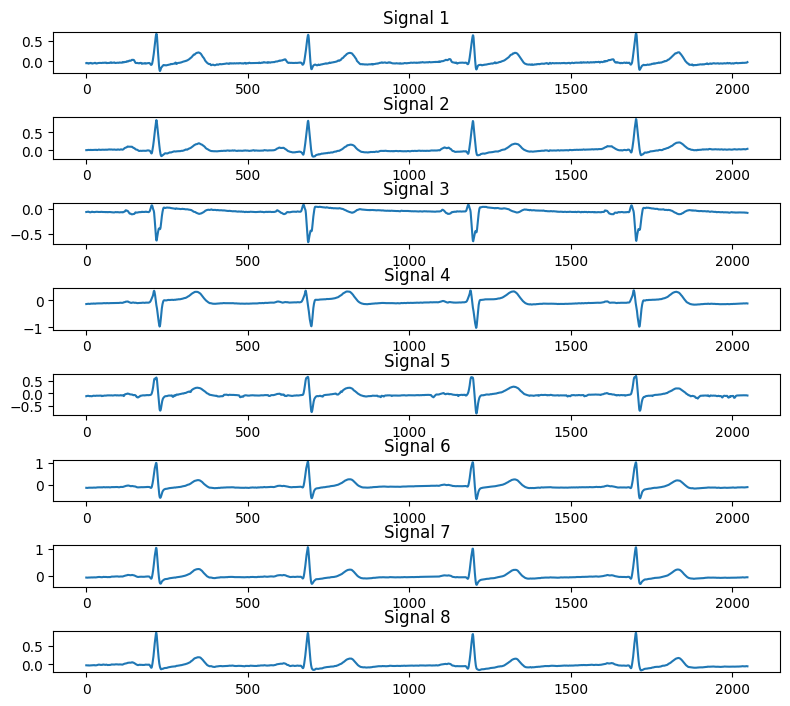

In [26]:
# 2048 - число точек вытягиваемых (примерно 4 с при 500 Гц)
transforms_data = transforms.Compose([
                        RandomSubsetTransform(2048),
                        ToTensor()
                        ])


train_ds = ECG_signal_data(split='train', transform=transforms_data)
val_ds = ECG_signal_data(split='val', transform=transforms_data)

train_ds[0]['signal'].shape
plot_signals_with_subplot(train_ds[0]['signal'])

In [9]:
train_ds[0]['signal']

200 2752


array([], shape=(0, 5000), dtype=float64)